<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/GO_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install gprofiler-official

In [43]:
from gprofiler import GProfiler
import pandas as pd
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

working_dir = r'\\hive.gladstone.internal\Huang-Lab\Lab Members\Tabuena\Patch_Seq_RNA_Analysis\pilot_patchseq\analysis_workspace'
os.chdir(working_dir)
gene_csv = 'gene_loadings.csv'

SyntaxError: invalid syntax (2352399772.py, line 6)

In [14]:



gene_df = pd.read_csv(gene_csv).set_index('gene_name')
display(gene_df.head())



,Component_0,Component_1,Component_2,Component_3,Component_4,Component_5
gene_name,,,,,,
0610030E20RIK,0.479263,0.000000,0.0,0.000000,0.000000,0.00000
1110004F10RIK,0.000000,2.374714,0.0,2.128296,0.000000,0.00000
1110059G10RIK,2.034128,0.000000,0.0,0.000000,0.000000,0.00000
1500011B03RIK,1.794556,0.000000,0.0,0.000000,0.074258,0.43745
1600012H06RIK,0.405203,0.000000,0.0,1.983558,0.000000,0.00000


In [59]:

# Define the number of top and bottom genes to extract
X = 250

# Dictionary to store the lists of tuples for each column
gene_dict = {}
# Iterate over each column in the DataFrame
for column in gene_df.columns:
    # Sort the column to get the top and bottom X genes
    sorted_genes = gene_df[column].sort_values(ascending=False)

    # Get the top X genes
    top_genes = sorted_genes.head(X).index.tolist()

    # Get the bottom X genes
    bottom_genes = sorted_genes.tail(X).index.tolist()

    # Store the top and bottom genes as a tuple
    gene_dict[column] = {'top': top_genes, 'bot': bottom_genes}


query_list = gene_dict[column]['top']



In [97]:
import gprofiler

# Initialize g:Profiler
gp = gprofiler.GProfiler(return_dataframe=True)

# Perform GO enrichment analysis
results = gp.profile(
    query=query_list,
    organism='mmusculus',  # Mouse organism code
    sources=['GO:BP'],    # GO Biological Process
    no_evidences=True     # Set to True to omit evidence codes
)
results['gene_ratio'] = results['intersection_size'] / results['term_size']
results = results.sort_values(by='gene_ratio', ascending=False)
# Print results
display(results.head())



,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,gene_ratio
65,GO:BP,GO:0015990,electron transport coupled proton transport,0.000062,True,"""The transport of protons against an electroch...",5,241,4,26944,0.016598,0.800000,query_1,[GO:0015988],0.800000
66,GO:BP,GO:0015988,"energy coupled proton transmembrane transport,...",0.000062,True,"""The transport of protons across a membrane an...",5,241,4,26944,0.016598,0.800000,query_1,[GO:1902600],0.800000
130,GO:BP,GO:1902307,positive regulation of sodium ion transmembran...,0.011649,True,"""Any process that activates or increases the f...",14,241,4,26944,0.016598,0.285714,query_1,"[GO:0010765, GO:0035725, GO:1902305, GO:1904064]",0.285714
102,GO:BP,GO:0099170,postsynaptic modulation of chemical synaptic t...,0.001497,True,"""Any process, acting in the postsynapse that r...",36,241,6,26944,0.024896,0.166667,query_1,[GO:0050804],0.166667
139,GO:BP,GO:0010765,positive regulation of sodium ion transport,0.018160,True,"""Any process that increases the frequency, rat...",32,241,5,26944,0.020747,0.156250,query_1,"[GO:0002028, GO:0006814, GO:0043270]",0.156250


C:\Users\dennis.tabuena\AppData\Local\Temp\ipykernel_9548\2228768458.py:100: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


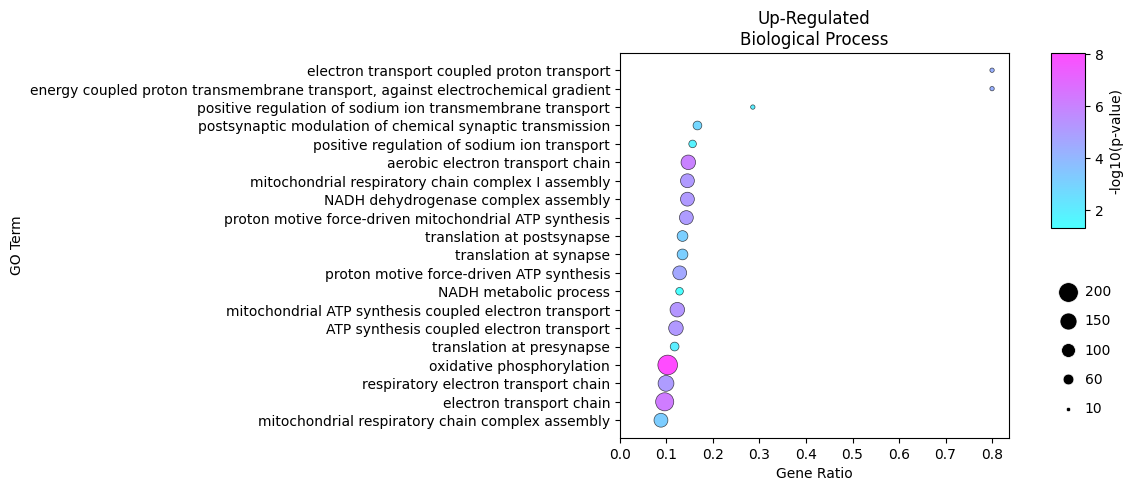

In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_go_enrichment(df,title, figsize=(4, 4)):
    """
    Plot GO enrichment analysis results as a dot plot with swapped axes, custom color bar placement,
    and sample min/max dots in separate subplots.

    Parameters:
    df (pd.DataFrame): DataFrame containing GO enrichment results with columns:
                       'name' (GO term names), 'p_value' (p-values),
                       'intersection_size' (size of the gene intersection),
                       'gene_ratio' (ratio of genes associated with the GO term).
    figsize (tuple): Figure size for the plot. Default is (4, 4).

    Returns:
    None
    """
    # Ensure the DataFrame contains the required columns
    required_columns = ['name', 'p_value', 'intersection_size', 'gene_ratio']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    # Sort results by gene_ratio and select top 20 terms
    top_results = df.sort_values(by='gene_ratio', ascending=False).head(20)

    # Extract relevant data
    go_terms = top_results['name']
    gene_ratios = top_results['gene_ratio']
    p_values = top_results['p_value']
    intersection_size = top_results['intersection_size']

    # Calculate -log10(p-value) for color
    neg_log_p_values = -np.log10(p_values)

    # Scale sizes so that intersection_size 1 maps to 10 and max maps to 200
    min_size, max_size = 10, 200
    min_intersection, max_intersection = intersection_size.min(), intersection_size.max()
    sizes = min_size + ((intersection_size - min_intersection) / (max_intersection - min_intersection)) * (max_size - min_size)

    # Round sizes to the nearest 10 increment
    sizes = np.round(sizes / 10) * 10

    # Create figure and subplots with custom size
    fig, axs = plt.subplots(2, 2, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.35]})

    # Main scatter plot spanning both rows in the first column
    ax_main = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
    scatter = ax_main.scatter(gene_ratios, go_terms, s=sizes,  # gene_ratio on x-axis, GO Term on y-axis
                              c=neg_log_p_values, cmap='cool', alpha=0.7, edgecolors='k', linewidth=0.5)

    # Add labels and title
    ax_main.set_xlabel('Gene Ratio')
    ax_main.set_ylabel('GO Term')
    ax_main.set_title('\n'.join(title))

    # Set x-axis limits to start at 0
    ax_main.set_xlim(left=0)

    # Flip y-axis to show the most enriched terms at the top
    ax_main.invert_yaxis()

    # Add custom color bar outside the main plot
    cax = axs[0, 1]
    cbar = plt.colorbar(scatter, cax=cax, orientation='vertical')
    cbar.set_label('-log10(p-value)')
    # cax.invert_yaxis()  # Flip the color bar orientation

    # Plot sample size dots
    ax_dots = axs[1, 1]
    min_size_dot = 10
    max_size_dot = 200
    num_dots = 5
    sizes = np.linspace(min_size_dot, max_size_dot, num_dots)  # Generate sizes from min to max
    sizes = np.round(sizes / 10) * 10  # Round sizes to the nearest 10 increment

    for i, size in enumerate(sizes):
        dot = ax_dots.scatter(1, i, s=size, color='black', edgecolors='w', linewidth=0.5, zorder=5)
        # Annotate the dots with their sizes, with left horizontal alignment and offset for visibility
        ax_dots.text(2, i, f'{int(size)}', ha='left', va='center',  color='black')

    # Hide all axes and labels on this subplot
    ax_dots.set_xticks([])
    ax_dots.set_yticks([])
    ax_dots.set_xlim([0,3])
    ax_dots.spines['top'].set_visible(False)
    ax_dots.spines['right'].set_visible(False)
    ax_dots.spines['left'].set_visible(False)
    ax_dots.spines['bottom'].set_visible(False)

    # Set limits
    ax_dots.set_xlim(0, 2)
    ax_dots.set_ylim(-1, num_dots)

    # Hide left plots and axes
    axs[0, 0].axis('off')
    axs[1, 0].axis('off')

    # Adjust layout for better fit
    plt.tight_layout()

    # Show the plot
    plt.show()
    return (fig, axs)

# Example usage
fig, axs = plot_go_enrichment(results,['Up-Regulated','Biological Process'], figsize=(6, 5))  # Adjust figsize as needed

